## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 549 (delta 66), reused 56 (delta 25), pack-reused 446
Receiving objects: 100% (549/549), 9.26 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [4]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [5]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = True

## Preprocessing

In [7]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
  # Lg Returns Only
  df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
  target_col = "cu_lme"
  
else:
  # Price Only
  df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
  target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [0]:
# Visualise the plots
# visualise_universe(universe_dict)

In [9]:
df_full.head(15)
# df_full.tail(5)

,cu_shfe,cu_lme,cu_comex_p,cu_comex_s,peso,sol,bdi,ted,vix,skew,gsci
date,,,,,,,,,,,
2006-09-13,0.001583,-0.013602,0.000590,0.055554,-0.000558,0.000307,0.029244,-0.004276,-0.064091,-0.048458,0.002624
2006-09-14,0.025695,-0.006098,-0.003100,-0.104881,0.000707,-0.001692,0.018715,0.005088,0.032559,-0.008086,-0.010694
2006-09-15,-0.027710,-0.021468,-0.019557,0.041104,-0.001172,0.000154,0.012050,0.002636,0.018019,0.124060,-0.004952
2006-09-18,0.006177,0.024153,0.030146,0.032495,0.000000,-0.000924,0.004920,0.002023,0.001699,-0.060186,0.007824
2006-09-19,0.023214,0.007613,-0.012512,0.138083,0.000000,0.000000,-0.000935,-0.000202,0.016835,-0.018385,-0.019642
2006-09-20,-0.026370,-0.005604,-0.001631,0.031900,0.001302,0.000000,-0.007278,-0.002226,-0.050503,-0.018730,-0.019389
2006-09-21,0.008013,0.016981,0.015312,0.077356,0.003527,0.000924,-0.010422,-0.003246,0.072790,-0.025002,0.012464
2006-09-22,0.014151,-0.000132,0.005101,0.053830,-0.002226,-0.000308,-0.015355,0.000609,0.027377,-0.006875,-0.013196
2006-09-25,-0.000562,-0.005409,0.002323,0.016873,0.001485,0.000616,-0.016332,-0.003458,-0.038046,0.015776,0.002186


### Normalizing the dataset

In [0]:
# Forecast length
# forecast_length = 5
forecast_length = 22

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [11]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 8
Explained Variance: [0.32287149 0.14685561 0.11797475 0.09850011 0.08345462 0.07538473
 0.05938562 0.04779432] 
Explained Variance Sum: 0.9522212562010387


### Slicing Series into Windows

In [0]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.5)

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 1000
patience = 100
disp_freq=10
fig_disp_freq=20


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1
dropout = 0.2

### Initialising the model

In [14]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 8 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (1405, 250, 8) 
data_y (1405,)


In [0]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

0.2


Epoch: 0 Train MSE: 0.03208 Val MSE: 0.25490  Time: 5.493


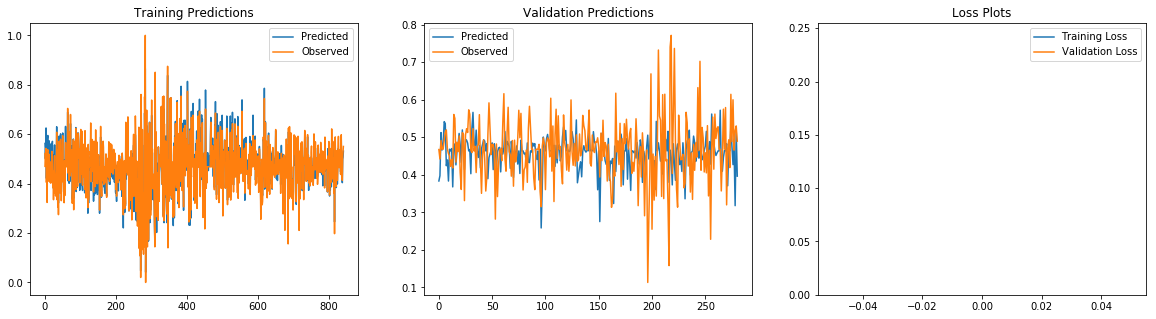

Epoch: 10 Train MSE: 0.05080 Val MSE: 0.32244  Time: 61.372
Epoch: 20 Train MSE: 0.03283 Val MSE: 0.29365  Time: 116.460


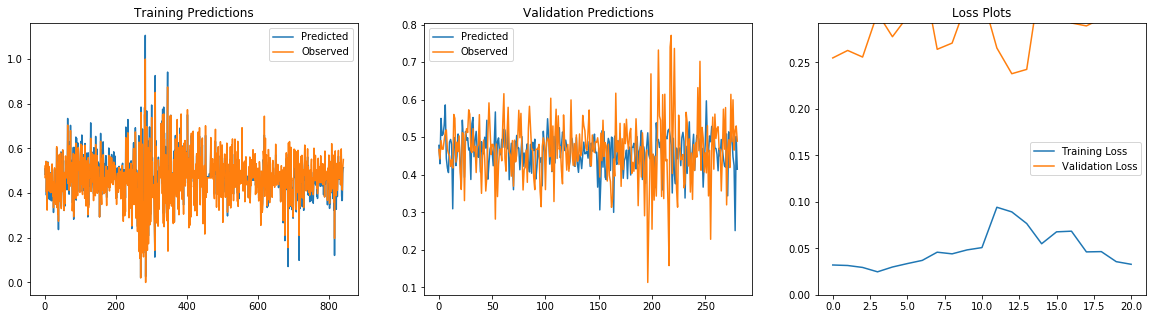

Epoch: 30 Train MSE: 0.03684 Val MSE: 0.26293  Time: 172.341
Epoch: 40 Train MSE: 0.05194 Val MSE: 0.29139  Time: 227.360


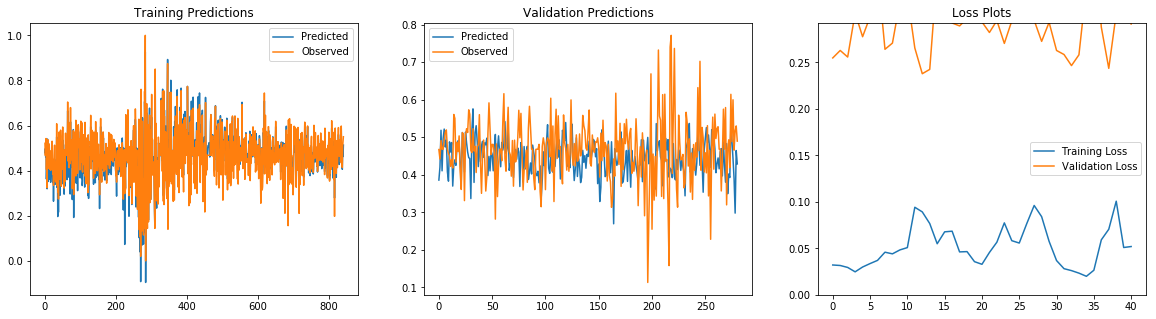

Epoch: 50 Train MSE: 0.05944 Val MSE: 0.25973  Time: 283.421
Epoch: 60 Train MSE: 0.03631 Val MSE: 0.40614  Time: 338.103


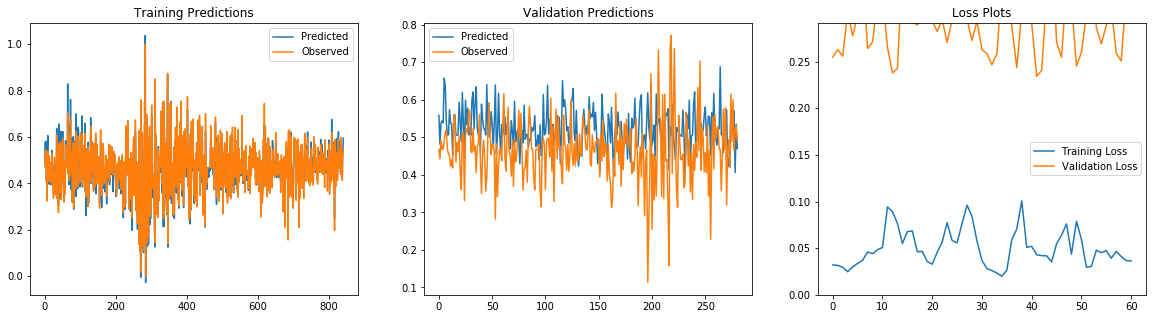

Epoch: 70 Train MSE: 0.01788 Val MSE: 0.26270  Time: 392.665
Epoch: 80 Train MSE: 0.04461 Val MSE: 0.26243  Time: 446.724


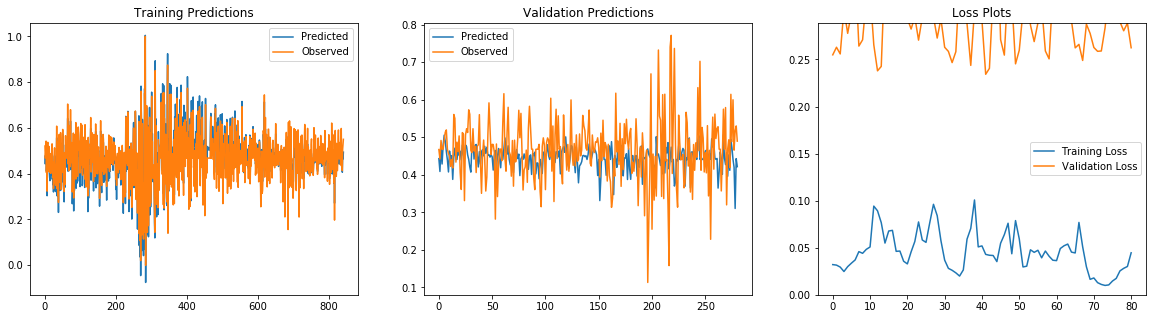

Epoch: 90 Train MSE: 0.03654 Val MSE: 0.26235  Time: 503.381
Epoch: 100 Train MSE: 0.03958 Val MSE: 0.26547  Time: 559.190


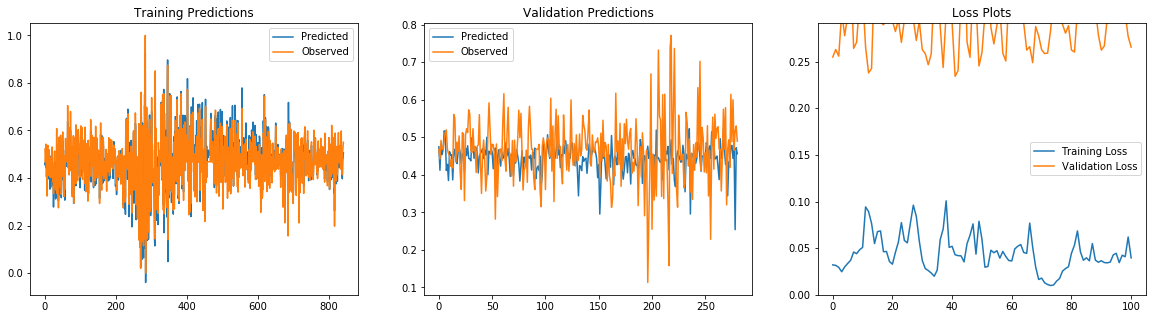

Epoch: 110 Train MSE: 0.02720 Val MSE: 0.26535  Time: 616.003
Epoch: 120 Train MSE: 0.04382 Val MSE: 0.27190  Time: 671.944


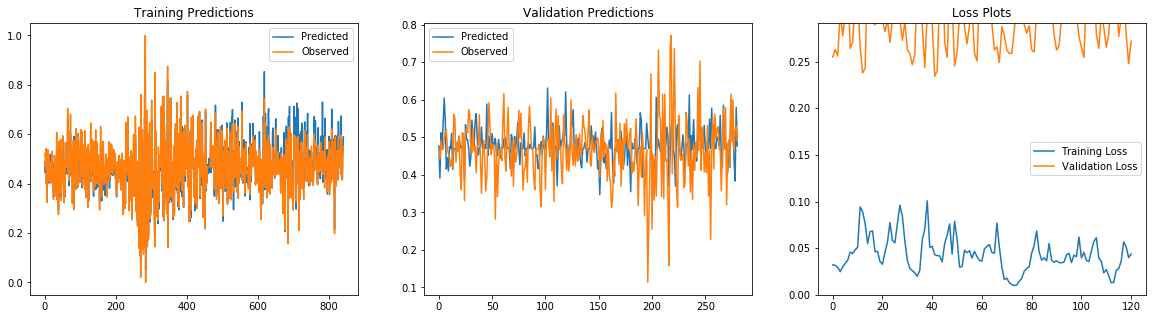

Epoch: 130 Train MSE: 0.02664 Val MSE: 0.39908  Time: 728.477
Epoch: 140 Train MSE: 0.04828 Val MSE: 0.33854  Time: 783.931


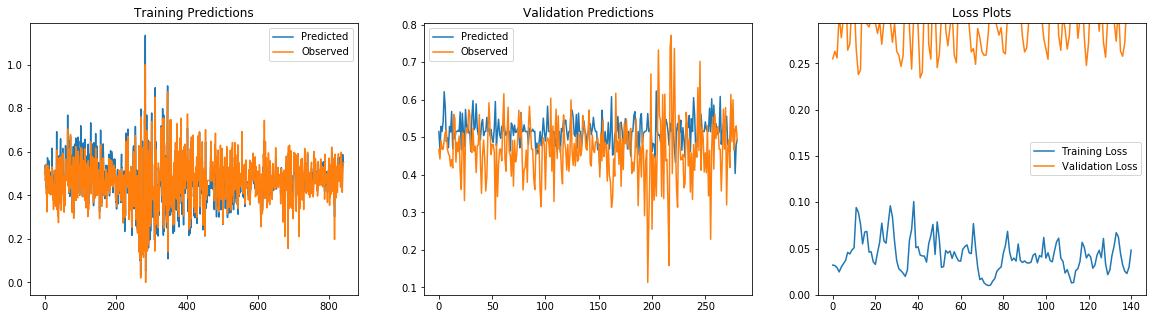

Epoch: 150 Train MSE: 0.06590 Val MSE: 0.34446  Time: 840.281
Epoch: 160 Train MSE: 0.04754 Val MSE: 0.34450  Time: 895.882


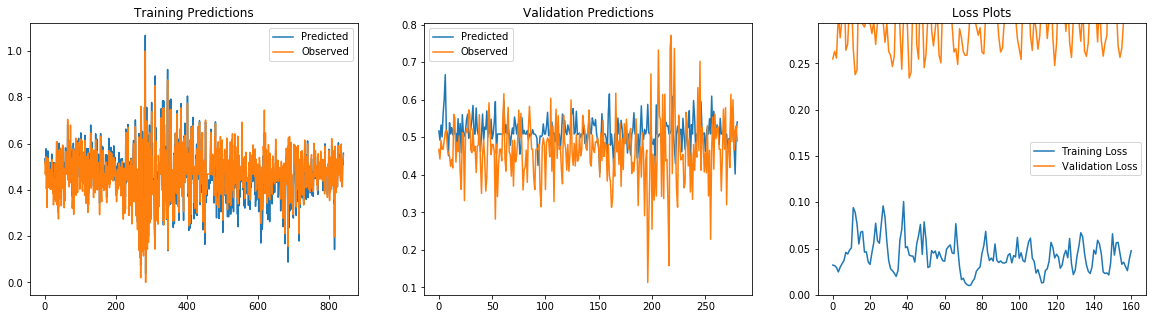

Epoch: 170 Train MSE: 0.04649 Val MSE: 0.36716  Time: 952.392
Epoch: 180 Train MSE: 0.01953 Val MSE: 0.27313  Time: 1008.337


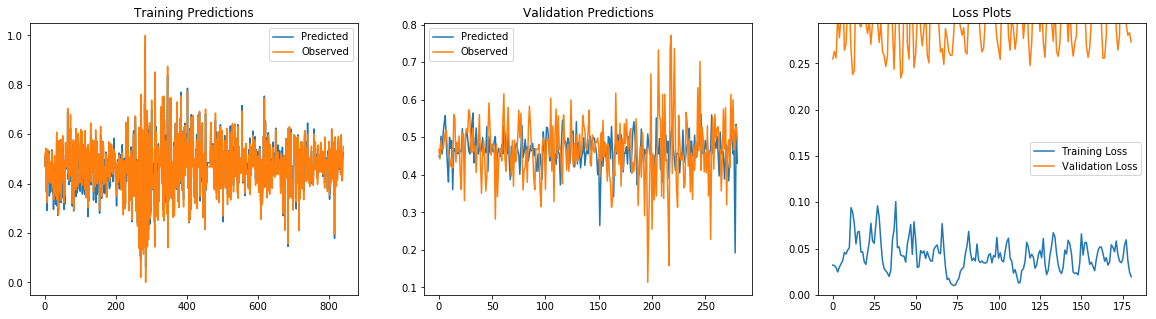

Epoch: 190 Train MSE: 0.05029 Val MSE: 0.25725  Time: 1064.790
Epoch: 200 Train MSE: 0.02119 Val MSE: 0.39574  Time: 1120.075


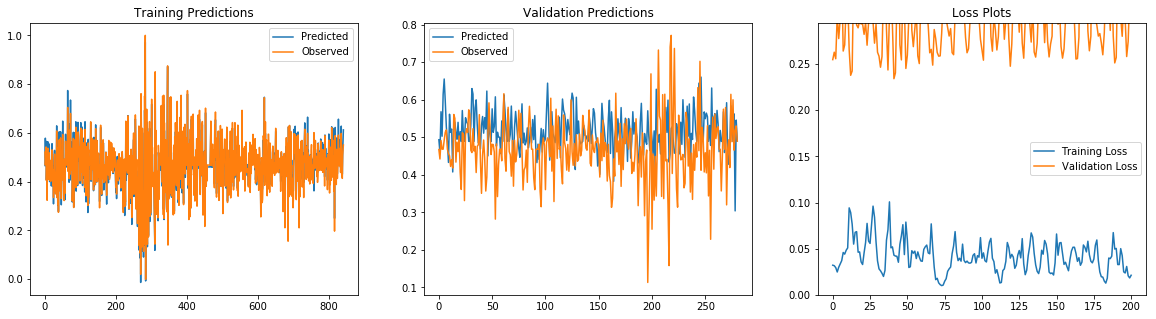

Epoch: 210 Train MSE: 0.02953 Val MSE: 0.34180  Time: 1175.347
Epoch: 220 Train MSE: 0.02853 Val MSE: 0.34774  Time: 1230.145


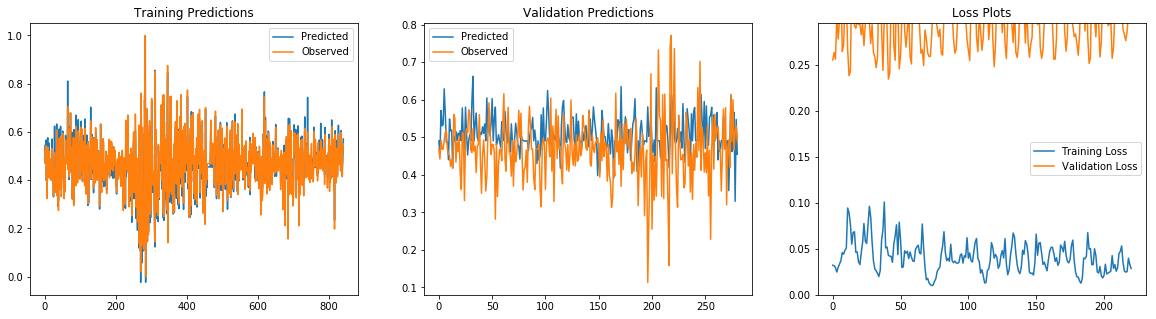

Epoch: 230 Train MSE: 0.01688 Val MSE: 0.36165  Time: 1286.441
Epoch: 240 Train MSE: 0.03472 Val MSE: 0.33569  Time: 1341.656


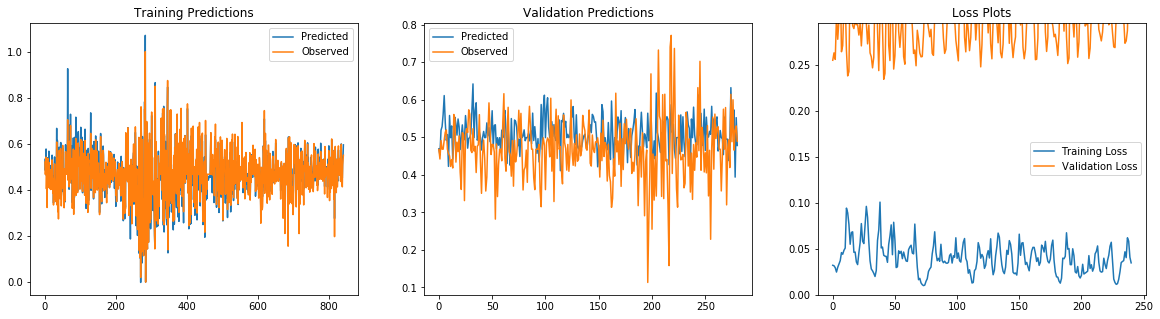

Early Stopping
Best Score: 0.23423900298800757


In [59]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=200)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()
print("Best Score:", learning.best_val_score)

In [20]:
learning.evaluate(learning.best_model, learning.test_loader)

0.1009544308075277

In [21]:
print(learning.logs["Validation Loss"])

[0.28953776749851867, 0.26848546720484395, 0.22998375570222576, 0.2428733988588815, 0.2572780308774358, 0.27567494212520505, 0.2554757391430729, 0.3091177847037536, 0.33116967652616125, 0.4484611321174377, 0.4051926721457485, 0.3390522351044353, 0.2721042149431765, 0.28251245861800117, 0.2725861971912859, 0.26786482800792544, 0.24104443987917645, 0.24277608165537334, 0.27831120677690063, 0.27047348192153875, 0.25463672719392066, 0.23867732689473978, 0.285189643024974, 0.3427605527151522, 0.4074502364596438, 0.39259543537669334, 0.2612203066883562, 0.2782767905035053, 0.2811572212341417, 0.27516907220209197, 0.2714455068323536, 0.2678903404928187, 0.23623478455051408, 0.23502746510760217, 0.3311338942246081, 0.36081291517753195, 0.30599017160218805, 0.2761938037397174, 0.3331948556933963, 0.3059607358165483, 0.29425950321862704, 0.27051349042573436, 0.2771935955061183, 0.3528013976019048, 0.30147393487950663, 0.24033458461965107, 0.24154095972135822, 0.26614216977591193, 0.3095672953595

### Saving Model Object

In [0]:
model_name = "log_returns_len" + str(forecast_length) + "_"
obj_name = "Learning" + "_" + model_name
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + obj_name, 'wb'))

In [0]:
# learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [26]:
model_save(model, 
           path="/content/gdrive/My Drive/Chai/Models/Pths/",
           name= "LSTM" + model_name, 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/Pths/LSTMlog_returns_len22__0_2299.pth


### Plotting

In [0]:
# Scaled Observed
train_true = scaler_data_y.inverse_transform(learning.y_train.numpy().reshape(-1, 1))
val_true  = scaler_data_y.inverse_transform(learning.y_val.numpy().reshape(-1, 1))
test_true  = scaler_data_y.inverse_transform(learning.y_test.numpy().reshape(-1, 1))

# Scaled Predicted
train_pred = scaler_data_y.inverse_transform(np.array(learning.train_predictions).reshape(-1, 1))
val_pred  = scaler_data_y.inverse_transform(np.array(learning.val_predictions).reshape(-1, 1))
test_pred = scaler_data_y.inverse_transform(np.array(learning.test_predictions).reshape(-1, 1))

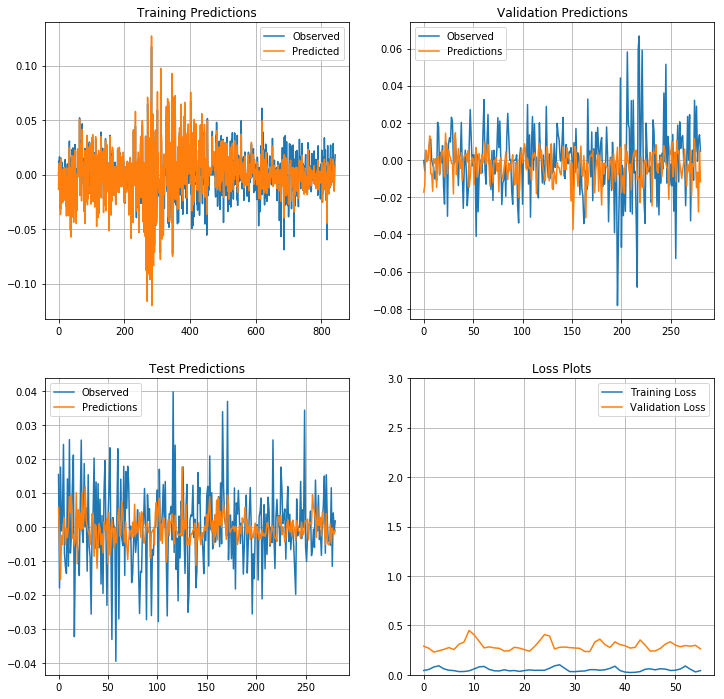

In [28]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()
ax[1, 1].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"
val_loss = learning.best_val_score

plt.savefig(path + model_name + str("LSTM_Val_" + str(val_loss)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))

plt.show()

# Results

In [0]:
test_increase = 1e-5 * np.array(range(test_true.shape[0]))
test_zeros = np.zeros(test_true.shape)

In [0]:
test_naive = shift(test_true.ravel(), forecast_length)[forecast_length:]

In [57]:
mse, mae, mde = evaluate(test_pred, test_true)
print("Predictions: ", 
      mse, mae, mde)

mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[forecast_length:])
print("naive",
    mse_naive, mae_naive, mde_naive)

mse_zeros, mae_zeros, mde_zeros = evaluate(test_zeros, test_true)
print("Flat",
    mse_zeros, mae_zeros, mde_zeros)

mse_increase, mae_increase, mde_increase = evaluate(test_increase, test_true)
print("Inflation",
    mse_increase, mae_increase, mde_increase)

Predictions:  0.00015469138 0.009600415 0.4804270462633452
naive 0.00031786045 0.013613554 0.4959526542538126
Flat 0.00014690885901432022 0.0090201874087642 0.0
Inflation 0.00014894396349752237 0.00918741371453408 0.5106318309038639


In [0]:
# The minimum validation loss
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [0]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          model_name,
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          use_lg_returns,
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          mse,
          mae,
          mde,
          path="/content/gdrive/My Drive/Chai/Models/CSVs/") 

NameError: ignored

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()